In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mod']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Dataframes
command: disjoint speaker split

In [4]:
dataframe_dir = '/home/muncok/DL/dataset/SV_sets/dataframes/'
data_dir = '/home/muncok/DL/dataset/SV_sets/reddots_r2015q4_v1/wav/'
data_df = pd.read_pickle('/home/muncok/DL/dataset/SV_sets/dataframes/Reddots_Dataframe.pkl')

In [10]:
import honk_sv.train as hk
import honk_sv.model as mod
import honk_sv.dataset as dset
import honk_sv.system as svs

### Dataset split

In [131]:
#TODO: correct splits
all_spks = data_df.spk.unique()
all_sents = data_df.sent.unique()
uttrs_counts = data_df.spk.value_counts()
sv_spks = list(uttrs_counts.index[:5])
si_spks = list(uttrs_counts.index[5:])

# SI Train

In [138]:
import random

si_with_df = data_df[(data_df.spk.isin(si_spks)) & ~(data_df.sent == 34)]

# with sampling
si_with_train = si_df.sample(frac=0.8)
si_with_test = si_df.drop(index=si_with_train.index)
si_with_val = si_with_test.sample(frac=0.5)
si_with_test = si_with_test.drop(index=si_with_val.index) 
print("[with] train:{}, val:{}, test:{}".format(len(si_with_train), len(si_with_val), len(si_with_test)))

[with] train:9245, val:1156, test:1155


In [139]:
si_without_df = data_df[(data_df.spk.isin(si_spks))].sample(n=len(si_with_df))

# without sampling
si_without_train = si_df.sample(frac=0.8)
si_without_test = si_df.drop(index=si_without_train.index)
si_without_val = si_without_test.sample(frac=0.5)
si_without_test = si_without_test.drop(index=si_without_val.index) 
print("[without] train:{}, val:{}, test:{}".format(len(si_without_train), len(si_without_val), len(si_without_test)))

[without] train:9245, val:1156, test:1155


In [172]:
import csv
import random

tags = ['train', 'val', 'test']
# choose a si split
sets = {'train':si_without_train, 'val':si_without_val, 'test':si_without_test}
manifest_dir = "manifests/reddots/"

for tag in tags:
    samples = []
    save_path = os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format("reddots", tag))
    with open(save_path, 'w') as f:
        for index, row in sets[tag].iterrows():
            file_path = os.path.join(data_dir, row.spk, row.file)
            label = si_spks.index(row.spk)
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        random.shuffle(samples)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))

manifests/reddots/si_reddots_train_manifest.csv was written
manifests/reddots/si_reddots_val_manifest.csv was written
manifests/reddots/si_reddots_test_manifest.csv was written


In [173]:
import os
import numpy as np

import honk_sv.model as mod
import honk_sv.train as hk

model = "res15"
dataset = "reddots"

global_config = dict(model=model, dataset=dataset,
                     no_cuda=False,  gpu_no=0,
                     n_epochs=30, batch_size=64,
                     lr=[1.0], schedule=[np.inf], dev_every=1, seed=0, use_nesterov=True,
                     cache_size=32768, momentum=0.90, weight_decay=0.00001,
                     num_workers=32, print_step=100,
                     )

builder = hk.ConfigBuilder(
                mod.find_config(model),
                dset.SpeechDataset.default_config(dataset),
                global_config)
parser = builder.build_argparse()
si_config = builder.config_from_argparse(parser)
si_config['model_class'] = mod.find_model(model)
hk.set_seed(si_config)

si_config['n_labels'] = len(si_spks)
manifest_dir = "manifests/reddots/"
for tag in ['train', 'val', 'test']:
    si_config['{}_manifest'.format(tag)]=os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format("reddots", tag))

# si_model = si_config['model_class'](si_config)

In [174]:
si_config['input_length'] = int(16000)
si_config['splice_length'] = 10
seq_len         = 10
embd_size       = si_config['n_mels']
n_layers        = 3
kernel          = (5, embd_size)
out_chs         = 128
res_block_count = 2
ans_size = si_config['n_labels']
si_model = mod.GatedCNN(seq_len, embd_size, n_layers, kernel, out_chs, res_block_count, ans_size)
si_config['input_file'] = ""
si_config['output_file'] = "models/reddots/si_reddots_gatedcnn_without_10f_3L.pt"
print(si_model)

GatedCNN (
  (conv_0): Conv2d(1, 128, kernel_size=(5, 40), stride=(1, 1), padding=(2, 0))
  (conv_gate_0): Conv2d(1, 128, kernel_size=(5, 40), stride=(1, 1), padding=(2, 0))
  (conv): ModuleList (
    (0): Conv2d(128, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (1): Conv2d(128, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (2): Conv2d(128, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
  )
  (conv_gate): ModuleList (
    (0): Conv2d(128, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (1): Conv2d(128, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (2): Conv2d(128, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
  )
  (b): ParameterList (
  )
  (c): ParameterList (
  )
  (fc): Linear (1280 -> 57)
)


In [175]:
hk.gatedcnn_train(si_config, model=si_model, loaders=None)

train step #99 accuracy: 0.296875, loss: 2.506197690963745
epoch #0, final dev accuracy: 0.31085526315789475
saving best model...
train step #199 accuracy: 0.234375, loss: 2.6990151405334473
epoch #1, final dev accuracy: 0.43256578947368424
saving best model...
train step #299 accuracy: 0.421875, loss: 2.065260648727417
train step #399 accuracy: 0.359375, loss: 2.1163434982299805
epoch #2, final dev accuracy: 0.4555921052631579
saving best model...
train step #499 accuracy: 0.5, loss: 1.7482473850250244
epoch #3, final dev accuracy: 0.4942434210526316
saving best model...
train step #599 accuracy: 0.46875, loss: 1.746472954750061
train step #699 accuracy: 0.53125, loss: 1.6122671365737915
epoch #4, final dev accuracy: 0.49588815789473684
saving best model...
train step #799 accuracy: 0.515625, loss: 1.7870292663574219
epoch #5, final dev accuracy: 0.5254934210526315
saving best model...
train step #899 accuracy: 0.34375, loss: 1.9581739902496338
train step #999 accuracy: 0.5, loss: 2.1

Process Process-12032:
Process Process-12018:
Process Process-12021:


train step #3299 accuracy: 0.65625, loss: 1.3105683326721191


Process Process-12015:
Process Process-12029:
Process Process-12026:


KeyboardInterrupt: 

Process Process-12003:
Process Process-12030:
Process Process-12028:
Process Process-12027:
Process Process-12020:
Process Process-12031:
Process Process-12002:
Process Process-12005:
Process Process-12008:
Process Process-12017:
Process Process-12011:
Process Process-12012:
Process Process-12010:
Process Process-12007:
Process Process-12022:
Process Process-12006:
Process Process-12001:
Process Process-12009:
Process Process-12019:
Process Process-12016:
Process Process-12014:
Process Process-12004:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-12013:
Process Process-12024:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/muncok/

Traceback (most recent call last):
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py",

KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


#### SV Enrollment & Test

In [145]:
import random
random.shuffle(sv_spks)
enroll_spks = sv_spks[:3]
test_spks = sv_spks[3:]

In [146]:
enroll_spks

['m0005', 'm0009', 'm0001']

In [147]:
test_spks

['f0002', 'm0002']

In [148]:
enroll_uttrs = pd.DataFrame()
dev_uttrs = pd.DataFrame()
enroll_pts = 0.3

sv_df = data_df[data_df.spk.isin(sv_spks) & (data_df.sent==34)]
# splits enroll and dev
for spk in enroll_spks:
    spk_df = sv_df[sv_df.spk == spk]
    assert(len(spk_df) != 0)
    enls = spk_df.sample(n=10)
    devs = spk_df.drop(index=enls.index).sample(n=10)
    enroll_uttrs = pd.concat([enls, enroll_uttrs])
    dev_uttrs = pd.concat([devs, dev_uttrs])
    
test_uttrs = sv_df[sv_df.spk.isin(test_spks)].sample(n=len(dev_uttrs))

In [139]:
dev_uttrs.to_pickle("./dev_uttrs.pkl")
test_uttrs.to_pickle("./test_uttrs.pkl")
# dev_uttrs = pd.read_pickle("./dev_uttrs.pkl")
# test_uttrs = pd.read_pickle("./test_uttrs.pkl")

In [164]:
import csv
import random

manifest_dir = "./manifests/reddots/enroll/"
# delete existing files
for file in os.listdir(manifest_dir):
    file_path = os.path.join(manifest_dir, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)
        

for spk in enroll_spks:
    samples = []
    save_path = os.path.join(manifest_dir,'enroll_{}_{}_manifest.csv'.format("reddots", spk))
    with open(save_path, 'w') as f:
        for index, row in enroll_uttrs[enroll_uttrs.spk == spk].iterrows():
            file_path = os.path.join(data_dir, row.spk, row.file)
            label = enroll_spks.index(row.spk)
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))    

./manifests/reddots/enroll/enroll_reddots_m0005_manifest.csv was written
./manifests/reddots/enroll/enroll_reddots_m0009_manifest.csv was written
./manifests/reddots/enroll/enroll_reddots_m0001_manifest.csv was written


In [184]:
si_model = mod.GatedCNN(seq_len, embd_size, n_layers, kernel, out_chs, res_block_count, ans_size)
si_model.load("models/reddots/si_reddots_gatedcnn_with_10f_3L.pt")

In [185]:
# enrolling speakers
# generating speaker models
si_config['batch_size'] = 1
manifest_dir = "./manifests/reddots/enroll/"
spk_models = dict()
si_model.limit = 100
for spk in enroll_spks:
    manifest_path = os.path.join(manifest_dir, 'enroll_{}_{}_manifest.csv'.format("reddots", spk))
    si_config['test_manifest'] =  manifest_path
    spk_models[spk] = svs.enroll_frame(si_config, model=si_model)

In [194]:
from scipy.spatial.distance import cosine
import itertools

for spk1, spk2 in itertools.combinations(enroll_spks,2):
    score = 1-cosine(spk_models[spk1], spk_models[spk2])
    print("{}, {}: {:.2f}".format(spk1, spk2, score))

m0005, m0009: 0.74
m0005, m0001: 0.84
m0009, m0001: 0.60


In [195]:
def pairwise_cosine(spk_models, test_in):
    spks = list(spk_models.keys())
    scores = np.zeros(len(spks))
    for k in spk_models.keys():
        signature = spk_models[k]
        scores[spks.index(k)] = 1-cosine(test_in, signature)
    return scores

In [196]:
corrects = 0
for idx, row in dev_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.spk, row.file)
    emb = svs.embed(si_config, si_model, audio_path)
    pred_spk = np.argmax(pairwise_cosine(spk_models, emb))
    label = enroll_spks.index(row.spk)
    if pred_spk == label:
        corrects += 1

print("SI Acc: {}".format(corrects/ len(dev_uttrs)))

SI Acc: 0.6333333333333333


In [197]:
nb_total_uttrs = len(dev_uttrs)+len(test_uttrs)
n_classes = len(enroll_spks)
score_vector = np.zeros((nb_total_uttrs, n_classes))
label_vector = np.zeros((nb_total_uttrs, n_classes))

spk_model = [v for k,v in spk_models.items()]
spk_labels = list(spk_models.keys())

i = 0
for idx, row in dev_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.spk, row.file)
    emb = svs.embed(si_config, si_model, audio_path)
    score_vector[i, :] = pairwise_cosine(spk_models, emb)
    label = spk_labels.index(row.spk)
    label_vector[i, label] = 1
    i+=1

for idx, row in test_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.spk, row.file)
    emb = svs.embed(si_config, si_model, audio_path)
    score_vector[i, :] = pairwise_cosine(spk_models, emb)
    i+=1

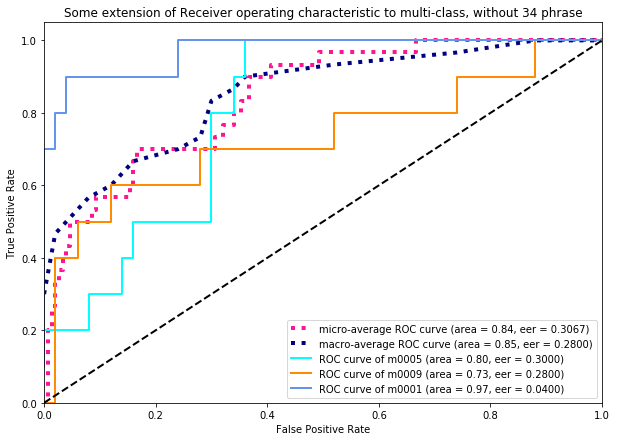

In [198]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
eer = dict()
thres = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thres[i] = roc_curve(label_vector[:, i], score_vector[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thres["micro"] = roc_curve(label_vector.ravel(), score_vector.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
eer["micro"] = fpr["micro"][np.nanargmin(np.abs(fpr["micro"] - (1 - tpr["micro"])))]

for i in range(n_classes):
    eer[i] = fpr[i][np.nanargmin(np.abs(fpr[i] - (1 - tpr[i])))]

from scipy import interp
from itertools import cycle
lw = 2
# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
eer["macro"] = fpr["macro"][np.nanargmin(np.abs(fpr["macro"] - (1 - tpr["macro"])))]
# Plot all ROC curves
fig = plt.figure(figsize=(10,7))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f}, eer = {1:0.4f})'
               ''.format(roc_auc["micro"], eer["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f}, eer = {1:0.4f})'
               ''.format(roc_auc["macro"], eer["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f}, eer = {2:0.4f})'
             ''.format(spk_labels[i], roc_auc[i], eer[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class, without 34 phrase')
plt.legend(loc="lower right")
plt.show()

Parameter Counts

In [ ]:
nb_params = 0
for param in si_model.parameters():
    nb_params += np.prod(param.size())
print(nb_params)    